In [2]:
# 분석에 필요한 패키지 로드
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fonm
from matplotlib import font_manager, rc
mpl.rcParams['axes.unicode_minus'] = False
font_path = 'C:/Windows/Fonts/정직_1.ttf'
font = fonm.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import pandas as pd
import seaborn as sns


In [3]:
# 성별코드와 연령대코드는 상관계수 확인가능
df = pd.read_csv('C:\\Workspace\\python\\빅데이터 지능형서비스 개발 팀프로젝트(21.9.27~10.6)\\Project-1\\조정범\\Data\\헬스케어데이터.csv')
df.drop(['기준년도', '진료내역일련번호', '데이터 기준일자'], axis = 1, inplace = True)
df['서식코드'] = df['서식코드'].apply(lambda x: 1 if x == 2 else 0) 
df['주상병코드'] = df['주상병코드'].apply(lambda x: x[:1])
df['부상병코드'] = df['부상병코드'].apply(lambda x: x[:1])
 # 해당 열들은 모두 범주형데이터임(나이브 베이지안으로 따로 분류모델작성)
# df.drop(['주상병코드', '부상병코드', '진료과목코드', '시도코드'], axis = 1, inplace = True)
df.head()

,가입자 일련번호,성별코드,연령대코드,시도코드,요양개시일자,서식코드,진료과목코드,주상병코드,부상병코드,요양일수,입내원일수,심결가산율,심결요양급여비용총액,심결본인부담금,심결보험자부담금,총처방일수
0,1,2,12,46,20191104,0,5,M,M,1,1,0.25,19240,9600,9640,0
1,1,2,12,46,20190806,0,1,E,N,1,1,0.25,145680,72800,72880,0
2,1,2,12,46,20190920,0,1,N,E,1,1,0.25,13240,6600,6640,3
3,1,2,12,46,20190807,1,1,E,N,7,21,0.25,861590,205810,655780,0
4,1,2,12,46,20190318,0,13,H,J,1,1,0.15,48440,14500,33940,3


In [4]:
df_train = df.copy() # 범주형데이터를 인코딩하기위한 테스트용 데이터프레임 형성 / 단순히 선언만하면 주소가 같아서 같이 변경되니 반드시 copy를 써서 주소까지 다르게 해줄것
df_train.dtypes # 데이터 형태확인
# 실질적인 범주형 데이터(인코딩필요) : 성별코드, 연령대코드, 시도코드, 요양개시일자(계절로 변경), 서식코드, 주상병, 부상병코드
# 요양개시일자 계절로 변환 / 봄 : 3 ~ 4, 여름 : 6 ~ 8, 가을 : 9 ~ 10, 겨울 : 11 ~ 2
df_train['요양개시일자'] = df_train['요양개시일자'].apply(lambda x: int(str(x)[4:6])) 
df_train['요양개시계절'] = df_train['요양개시일자'].apply(lambda x: '봄' if x >= 3 and x <= 4 else '여름' if x >= 5 and x <= 8 else '가을' if x >= 9 and x <= 10 else '겨울')
df_train['상병코드조합'] = df_train['주상병코드'] + df_train['부상병코드'] 
df_train.drop(['가입자 일련번호','입내원일수', '요양일수', '심결가산율', '심결요양급여비용총액', '심결본인부담금', '심결보험자부담금', '총처방일수'], axis = 1, inplace = True)
df_train

,성별코드,연령대코드,시도코드,요양개시일자,서식코드,진료과목코드,주상병코드,부상병코드,요양개시계절,상병코드조합
0,2,12,46,11,0,5,M,M,겨울,MM
1,2,12,46,8,0,1,E,N,여름,EN
2,2,12,46,9,0,1,N,E,가을,NE
3,2,12,46,8,1,1,E,N,여름,EN
4,2,12,46,3,0,13,H,J,봄,HJ
...,...,...,...,...,...,...,...,...,...,...
13178340,2,1,47,10,0,21,P,P,가을,PP
13178341,2,1,47,12,0,11,J,J,겨울,JJ
13178342,2,1,47,6,0,12,H,P,여름,HP
13178343,2,1,47,6,1,11,P,P,여름,PP


In [5]:
# 범주형 데이터 원-핫 인코딩
# 출처 : 프로그래머스(https://programmers.co.kr/learn/courses/21/lessons/11044)
df_train1 = df_train[["성별코드", "진료과목코드", "주상병코드", "요양개시계절", '서식코드']].copy() # 테스트로 사용할 컬럼들
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data
dummy_columns = ["성별코드", "주상병코드", "진료과목코드", "요양개시계절"]
df_train1_dummy = dummy_data(df_train1, dummy_columns)

In [6]:
# 원-핫 인코딩이 되었는지 확인
print(f'인코딩 전 데이터구조 : {df_train1.shape} / 인코딩 후 데이터구조 : {df_train1_dummy.shape}')

인코딩 전 데이터구조 : (13178345, 5) / 인코딩 후 데이터구조 : (13178345, 62)


<AxesSubplot:title={'center':'특성별 피어슨 상관계수'}>

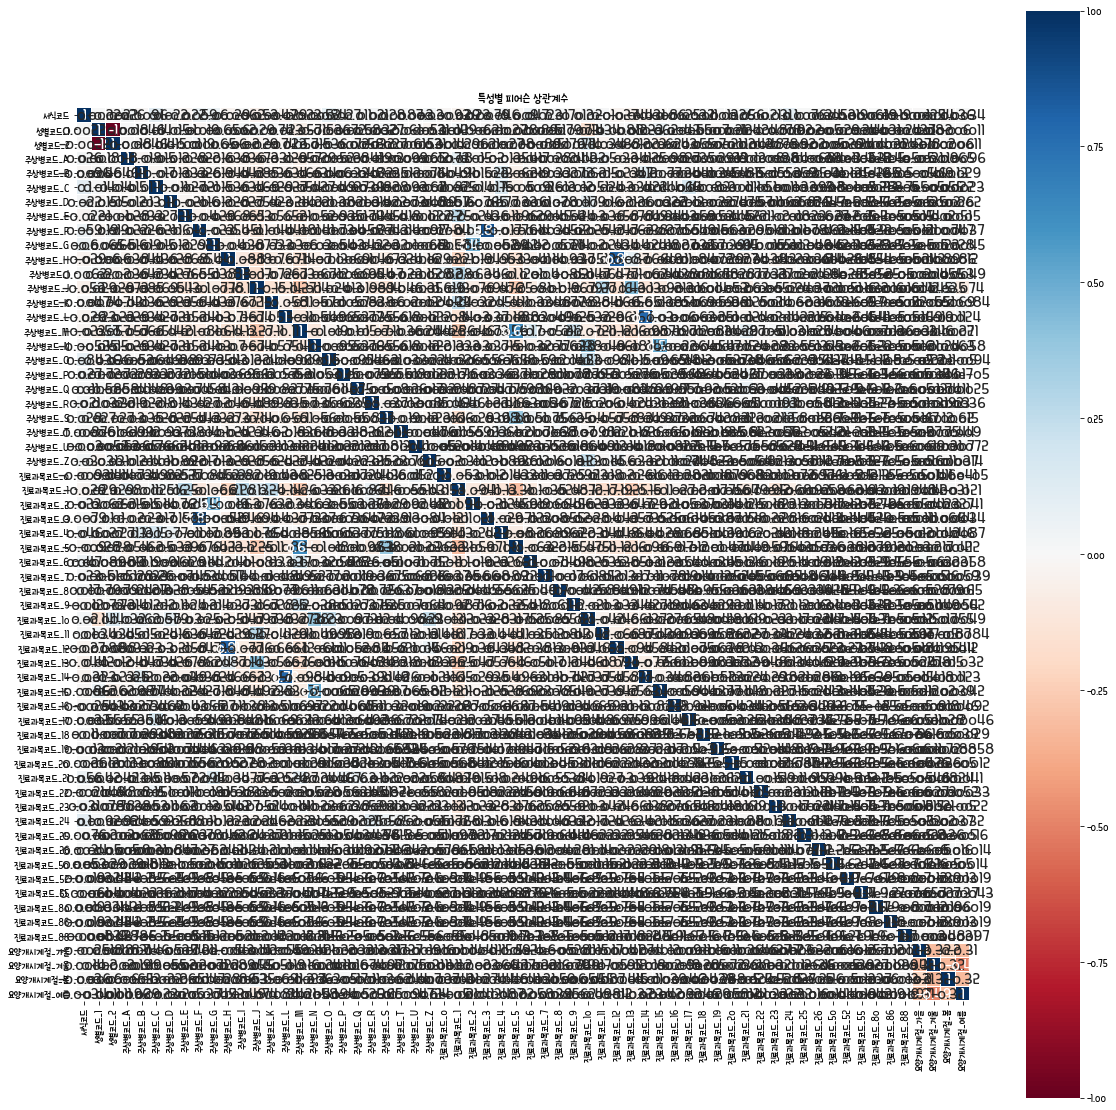

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize = (20, 20))
plt.title('특성별 피어슨 상관계수')
sns.heatmap(df_train1_dummy.astype(float).corr(), linewidth = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True, annot_kws = {'size' : 16})

In [30]:
# 상관계수 시각화 코드 : 범주형데이터는 반드시 인코딩해준후 해야함
# colormap = plt.cm.RdBu
# plt.figure(figsize = (10, 10))
# plt.title('특성별 피어슨 상관계수')
# sns.heatmap(df.astype(float).corr(), linewidth = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True, annot_kws = {'size' : 16})

In [31]:
# KNN모델 테스트
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# X, y = load_digits(return_X_y = True) # X는 digits의 data 카테고리로, y는 target 카테고리의 데이터로 이해하면됨.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 7)
# print(len(digits.target_names))
# len(X_train), len(X_test), len(X_train) + len(X_test)

In [32]:
df_train1_dummy['서식코드'] = df_train['서식코드'].copy()
print(df_train1_dummy.columns[1:])
print(df_train1_dummy.columns[0])

Index(['성별코드_1', '성별코드_2', '주상병코드_A', '주상병코드_B', '주상병코드_C', '주상병코드_D',
       '주상병코드_E', '주상병코드_F', '주상병코드_G', '주상병코드_H', '주상병코드_I', '주상병코드_J',
       '주상병코드_K', '주상병코드_L', '주상병코드_M', '주상병코드_N', '주상병코드_O', '주상병코드_P',
       '주상병코드_Q', '주상병코드_R', '주상병코드_S', '주상병코드_T', '주상병코드_U', '주상병코드_Z',
       '진료과목코드_0', '진료과목코드_1', '진료과목코드_2', '진료과목코드_3', '진료과목코드_4', '진료과목코드_5',
       '진료과목코드_6', '진료과목코드_7', '진료과목코드_8', '진료과목코드_9', '진료과목코드_10',
       '진료과목코드_11', '진료과목코드_12', '진료과목코드_13', '진료과목코드_14', '진료과목코드_15',
       '진료과목코드_16', '진료과목코드_17', '진료과목코드_18', '진료과목코드_19', '진료과목코드_20',
       '진료과목코드_21', '진료과목코드_22', '진료과목코드_23', '진료과목코드_24', '진료과목코드_25',
       '진료과목코드_26', '진료과목코드_50', '진료과목코드_52', '진료과목코드_55', '진료과목코드_80',
       '진료과목코드_86', '진료과목코드_88', '요양개시계절_가을', '요양개시계절_겨울', '요양개시계절_봄',
       '요양개시계절_여름'],
      dtype='object')
서식코드


In [33]:
# 인코딩 완료데이터를 훈련용과 시험용으로 분류 # 예상소요시간 : 
X = df_train1_dummy.iloc[:, 1:]
y = df_train1_dummy.iloc[:, 0]
# from sklearn.preprocessing import MinMaxScaler 
# scaler = MinMaxScaler() 
# scaler.fit(X) 
# X_scaled = scaler.transform(X) 
# df_scaled = pd.DataFrame(data=X_scaled, columns=['성별코드', '연령대코드']) 
# df_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 7)

In [ ]:
from sklearn.metrics import accuracy_score
n = 7
neigh_n = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
neigh_n.fit(X_train, y_train)
y_pred = neigh_n.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy*100}')

In [ ]:
import joblib
joblib.dump(neigh_n, 'C:\\Workspace\\python\\빅데이터 지능형서비스 개발 팀프로젝트(21.9.27~10.6)\\Project-1\\조정범\\Data\\머신러닝모델\\KNN모델1.pkl')

In [ ]:
import matplotlib.pyplot as plt
k_list = range(1,25)
accuracies = []
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
  classifier.fit(X_train, y_train)
  accuracies.append(classifier.score(X_test, y_test))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Test Accuracy")
plt.title("Classifier Accuracy")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = neigh_n.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (7, 5))
sns.heatmap(cf, annot = True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')